<a href="https://colab.research.google.com/github/auroramugnai/ArXivClassification/blob/main/ArXivClassification/category_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ArXivClassification can classify scientific articles based on their categories
Here we perform a supervised classification where the labels are the articles' lists of categories and the features can be either their abstracts and titles or their lists of keywords, extracted from abstract and title.

⚡**N.B.**: If you just want to play with the classification and not with the pre-processing, you can find a zip file (`processed_data.zip`) in this repository with some already processed data. If this is the case, you can run section 0) and then skip to section 4).

# 0) Initial setup

Clone the github repository and move to the inner directory.

In [1]:
!git clone https://github.com/auroramugnai/ArXivClassification.git
%cd ArXivClassification/ArXivClassification

Cloning into 'ArXivClassification'...
remote: Enumerating objects: 1913, done.
remote: Counting objects: 100% (555/555), done.
remote: Compressing objects: 100% (203/203), done.
remote: Total 1913 (delta 412), reused 457 (delta 350), pack-reused 1358
Receiving objects: 100% (1913/1913), 58.17 MiB | 15.75 MiB/s, done.
Resolving deltas: 100% (1027/1027), done.
/content/ArXivClassification/ArXivClassification


In [2]:
import random
import zipfile

import pandas as pd

import utils

In [3]:
SEED = 42 # fix random seed for reproducibility
random.seed(SEED)

# 1) Dataset building

In [ ]:
import json

import dask.bag as db

## 1.1 Download the dataset


The following line of code comes from clicking on "Copy API command" in https://www.kaggle.com/datasets/Cornell-University/arxiv.

In [ ]:
!kaggle datasets download -d Cornell-University/arxiv

Dataset URL: https://www.kaggle.com/datasets/Cornell-University/arxiv
License(s): CC0-1.0
100% 1.28G/1.28G [00:18<00:00, 64.3MB/s]
100% 1.28G/1.28G [00:18<00:00, 76.1MB/s]


Unzip the downloaded file.

In [ ]:
with zipfile.ZipFile('./arxiv.zip', 'r') as zip_ref:
    zip_ref.extractall()

The unzipping creates an "arxiv-metadata-oai-snapshot.json". We now create a dask bag out of it.

In [ ]:
path = "./arxiv-metadata-oai-snapshot.json"
arxiv_data = db.read_text(path).map(json.loads)

# See how elements of the dataset look like.
arxiv_data.take(1)

({'id': '0704.0001',
  'submitter': 'Pavel Nadolsky',
  'authors': "C. Bal\\'azs, E. L. Berger, P. M. Nadolsky, C.-P. Yuan",
  'title': 'Calculation of prompt diphoton production cross sections at Tevatron and\n  LHC energies',
  'comments': '37 pages, 15 figures; published version',
  'journal-ref': 'Phys.Rev.D76:013009,2007',
  'doi': '10.1103/PhysRevD.76.013009',
  'report-no': 'ANL-HEP-PR-07-12',
  'categories': 'hep-ph',
  'license': None,
  'abstract': '  A fully differential calculation in perturbative quantum chromodynamics is\npresented for the production of massive photon pairs at hadron colliders. All\nnext-to-leading order perturbative contributions from quark-antiquark,\ngluon-(anti)quark, and gluon-gluon subprocesses are included, as well as\nall-orders resummation of initial-state gluon radiation valid at\nnext-to-next-to-leading logarithmic accuracy. The region of phase space is\nspecified in which the calculation is most reliable. Good agreement is\ndemonstrated with d

## 1.2 Get rid of some unnecessary infomation

In [ ]:
# Get the latest version of the articles.
get_latest_version = lambda x: x['versions'][-1]['created']

# Only keep articles published after 2022.
is_after_2022 = lambda x: int(get_latest_version(x).split(' ')[3]) > 2022

# Only keep some information.
cut_info = lambda x: {'id': x['id'],
                      'title': x['title'],
                      'category':x['categories'].split(' '),
                      'abstract':x['abstract'],}

arxiv_data_filtered = (arxiv_data.filter(is_after_2022).map(cut_info).compute())


# Create a pandas dataframe and save it to csv.
df = pd.DataFrame(arxiv_data_filtered)
df.head()

,id,title,category,abstract
0,0705.1329,Third Order Newton's Method for Zernike Polyno...,"[math.NA, cs.NA]",The Zernike radial polynomials are a system ...
1,0706.0190,Quantum Properties and Gravitational Field of ...,[physics.gen-ph],We find that a field with oscillations of ma...
2,0706.0725,Factorization of quadratic polynomials in the ...,"[math.AC, math.GM, math.NT, math.RA]",We establish necessary and sufficient condit...
3,0706.0859,"Profinite complexes of curves, their automorph...","[math.AG, math.NT]","Let ${\cal M}_{g,[n]}$, for $2g-2+n>0$, be t..."
4,0707.0434,Another generalization of Mason's ABC-theorem,[math.NT],We show a generalization of Mason's ABC-theo...


Visualize the dataset distribution.

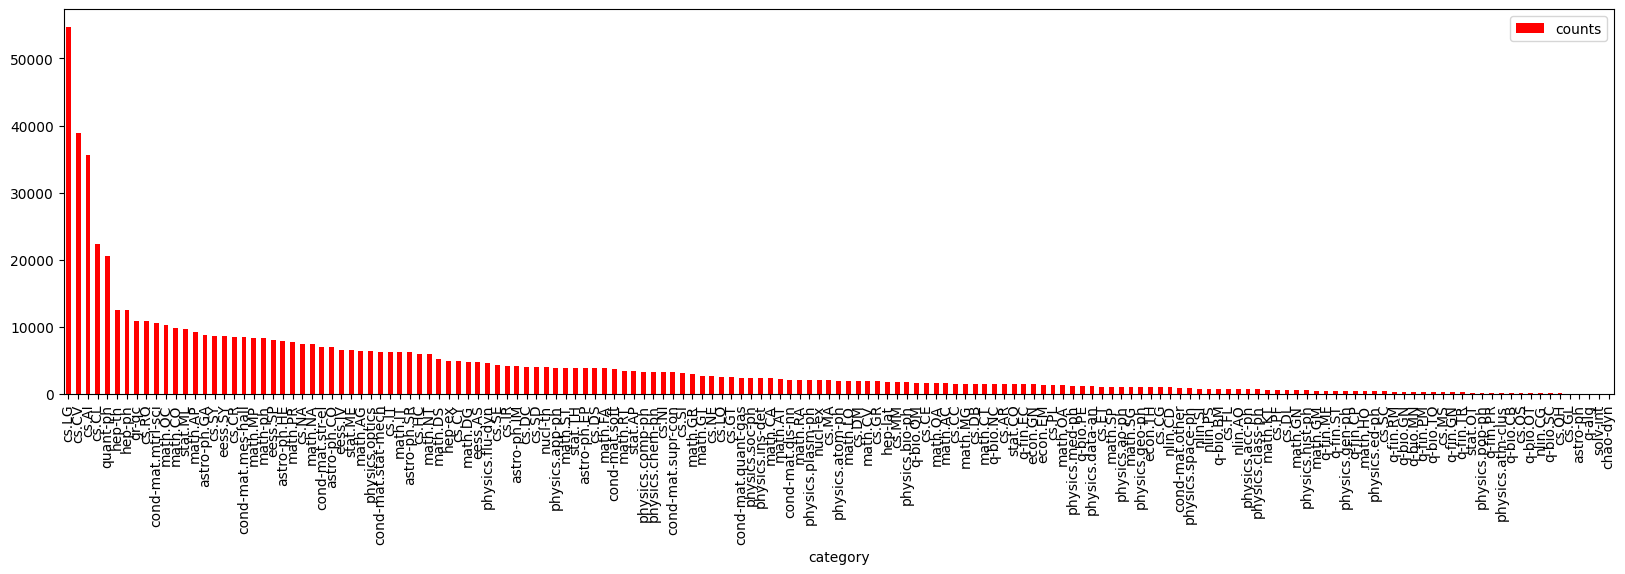

In [ ]:
# Get single-category occurrences.
utils.categories_as_lists(df) # take "category" as a column of lists
df_exp = df.explode("category")

# Create a dictionary of the form {category: counts}.
dict_counts_exp = utils.plot_df_counts(df_exp, col="category")

## 1.3 Keep 20 categories

In [ ]:
# Get the list of all the single categories.
C  = list(dict_counts_exp.keys())
print(f'Number of categories appearing in the dataset: {len(C)}')

num_cat_to_keep = 20
sub_C = random.sample(C, num_cat_to_keep)  # a subset of C
print(f'Number of categories appearing in the dataset: {len(sub_C)}')

# Only keep articles whose categories are (all) in sub_C.
utils.categories_as_lists(df) # take "category" as a column of lists
check = lambda x: set(x).issubset(sub_C)
df = df.loc[df["category"].apply(check).loc[lambda x: x].index]
df = df.reset_index(drop=True)
df.head()

Number of categories appearing in the dataset: 159
Number of categories appearing in the dataset: 20


,id,title,category,abstract
0,0709.0078,Holding strategies in a bus-route model,[physics.soc-ph],A major source of delays in public transport...
1,0711.1115,Gravitational-Wave Data Analysis. Formalism an...,[gr-qc],The article reviews the statistical theory o...
2,0807.3054,Deformations of Symmetric Simple Modular Lie (...,[math.RT],We say that a Lie (super)algebra is ''symmet...
3,0907.5180,"Brunet-Derrida particle systems, free boundary...",[math.PR],We consider a branching-selection system in ...
4,1001.3619,The measurability of hitting times,[math.PR],Under very general conditions the hitting ti...


## 1.4 Remove categories with \#counts < `num_min`
First, find categories that have less than `num_min` counts, namely `cat_to_drop`.
Then, only keep those articles whose lists of categories have no intersection with `cat_to_drop`.


In [ ]:
num_min = 100
cat_to_drop = [cat for cat,count in dict_counts_exp.items() if count<num_min]

utils.categories_as_lists(df) # take "category" as a column of lists
has_no_intersection = lambda x: not (set(x) & set(cat_to_drop))
df = df.loc[df["category"].apply(has_no_intersection).loc[lambda x: x].index]

df = df.reset_index(drop=True)
print(f'Number of articles in the dataset: {len(df)}')
df.tail()

Number of articles in the dataset: 26942


,id,title,category,abstract
26937,hep-ph/0005183,Two-Loop QCD Anomalous Dimensions of Flavour-C...,[hep-ph],We calculate the two-loop QCD anomalous dime...
26938,hep-ph/9806345,On positivity of parton distributions,[hep-ph],We discuss the bounds on polarized parton di...
26939,math/0305442,Adjoint and coadjoint orbits of the Poincar\'e...,[math.RT],In this paper we give an effective method fo...
26940,math/0505619,Stabilization phenomena in Kac-Moody algebras ...,[math.RT],Let X be the Dynkin diagram of a symmetrizab...
26941,math/0509562,Invariant bilinear differential operators,[math.RT],I classified bilinear differential operators...


Visualize the dataset distribution.

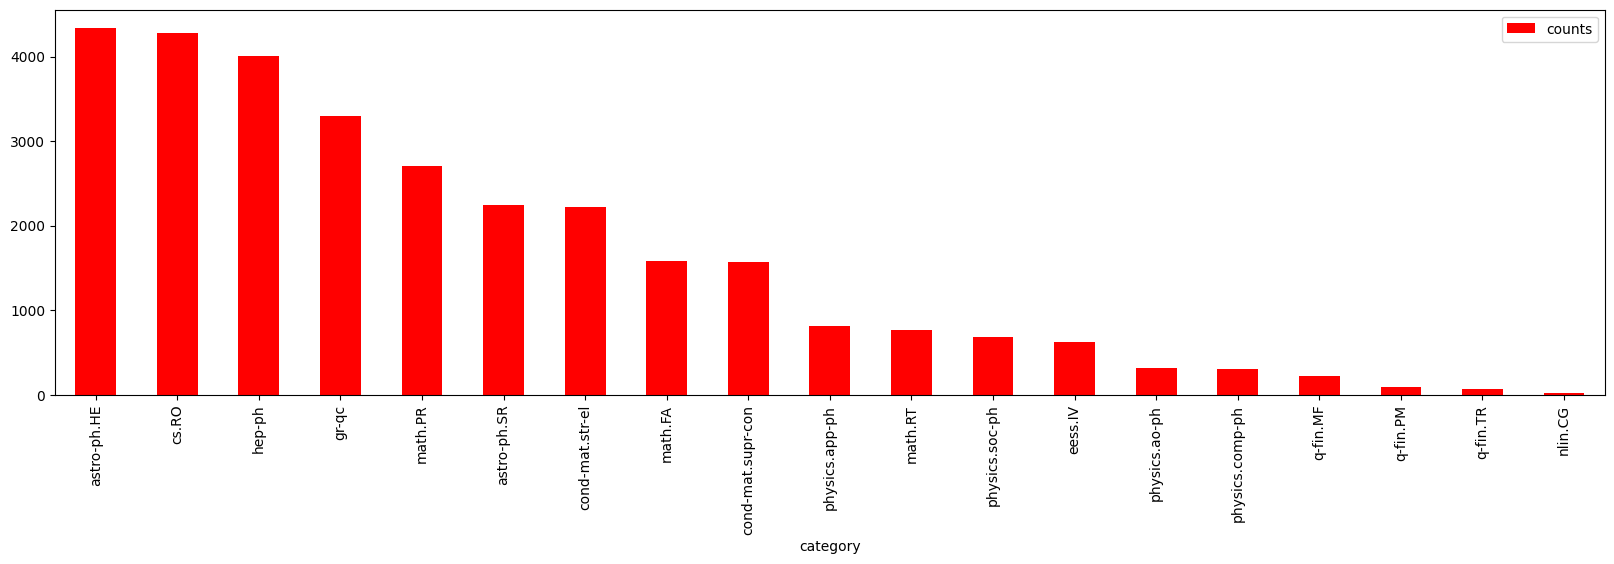

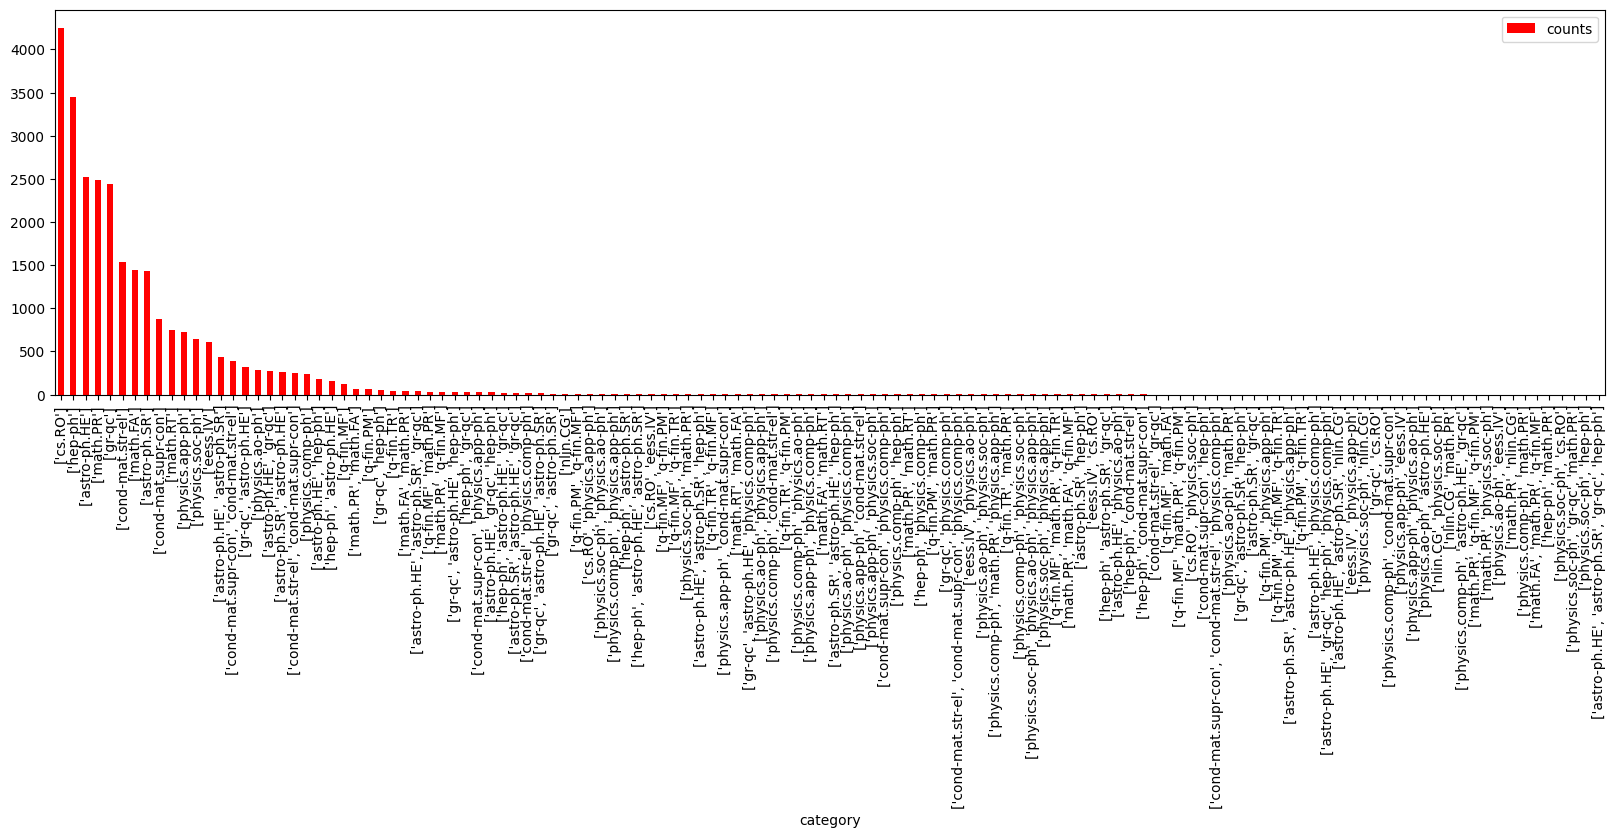

In [ ]:
# Get single-category occurrences.
utils.categories_as_lists(df) # take "category" as a column of lists
_ = utils.plot_df_counts(df.explode("category"), col="category")

# Get list-of-categories occurrences.
utils.categories_as_strings(df) # take "category" as a column of strings
_ = utils.plot_df_counts(df, col="category")

# 2) Text-processing

In [ ]:
!pip install -U spacy -q
!python -m spacy download en_core_web_md -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 16.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
import en_core_web_md
import spacy
from tqdm import tqdm

Clean out the strings (this step will take a while).

In [ ]:
# Remove stop words, punctuation, special characters, numbers...
spacy.prefer_gpu()
nlp = spacy.load("en_core_web_md")
tqdm.pandas() # to display progress bar


# ... first on abstracts ...
abs_cleaner = lambda x: utils.text_cleaner(text=x["abstract"], nlp=nlp)
df["clean_abstract"] = df.progress_apply(abs_cleaner, axis=1)

# ... then on titles.
tit_cleaner = lambda x: utils.text_cleaner(text=x["title"], nlp=nlp)
df["clean_title"] = df.progress_apply(tit_cleaner, axis=1)

df.tail()

100%|██████████| 26942/26942 [04:15<00:00, 105.25it/s]


,id,title,category,abstract,clean_abstract,clean_title
26937,hep-ph/0005183,Two-Loop QCD Anomalous Dimensions of Flavour-C...,['hep-ph'],We calculate the two-loop QCD anomalous dime...,calculate loop qcd anomalous dimension matrix ...,loop qcd anomalous dimension flavour change qu...
26938,hep-ph/9806345,On positivity of parton distributions,['hep-ph'],We discuss the bounds on polarized parton di...,discuss bound polarize parton distribution fol...,positivity parton distribution
26939,math/0305442,Adjoint and coadjoint orbits of the Poincar\'e...,['math.RT'],In this paper we give an effective method fo...,paper effective method find unique representat...,adjoint coadjoint orbit group
26940,math/0505619,Stabilization phenomena in Kac-Moody algebras ...,['math.RT'],Let X be the Dynkin diagram of a symmetrizab...,let x dynkin diagram symmetrizable kac moody a...,stabilization phenomena kac moody algebra quiv...
26941,math/0509562,Invariant bilinear differential operators,['math.RT'],I classified bilinear differential operators...,classify bilinear differential operator act sp...,invariant bilinear differential operator


In [ ]:
# Join the strings.
df["clean_text"] = df["clean_title"] + " " + df["clean_abstract"]

# 3) Keyword extraction
⚡**N.B**: if you're going to use `clean_text` as the feature for the classification, you won't need keywords, so you can skip this section.

In [ ]:
!pip install KeyBERT -q
!pip install keyphrase-vectorizers -q

In [ ]:
from keybert import KeyBERT
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
kw_model = KeyBERT('all-mpnet-base-v2')
top_n = 4

extraction = lambda x: utils.extract_kws(text=x["clean_text"],
                                        kw_model=kw_model,
                                        seed=x["clean_title"].split(" "),
                                        top_n=top_n)

df["keywords"] = df.progress_apply(extraction, axis=1)

# 4) Multilabel Classification


In [4]:
!pip install iterative-stratification
!pip install neattext
!pip install scikit-multilearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.7/114.7 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.4/89.4 kB 2.2 MB/s eta 0:00:00


In [5]:
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score, classification_report, \
                            multilabel_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MultiLabelBinarizer, normalize
from sklearn.svm import SVC, LinearSVC
from yellowbrick.classifier import ClassificationReport

In [7]:
with zipfile.ZipFile("./processed_data.zip", "r") as z:
    z.extractall()

df = pd.read_csv("processed_data_01.csv", dtype=str)

# Create a dictionary of the form {category: counts}.
d = utils.plot_df_counts(df.explode("category"), col="category")
print(d.values())
df.tail()

,id,title,category,abstract,clean_abstract,clean_title,clean_text
26904,hep-ph/0005183,Two-Loop QCD Anomalous Dimensions of Flavour-C...,['hep-ph'],We calculate the two-loop QCD anomalous dime...,calculate loop qcd anomalous dimension matrix ...,loop qcd anomalous dimension flavour change qu...,loop qcd anomalous dimension flavour change qu...
26905,hep-ph/9806345,On positivity of parton distributions,['hep-ph'],We discuss the bounds on polarized parton di...,discuss bound polarize parton distribution fol...,positivity parton distribution,positivity parton distribution discuss bound p...
26906,math/0305442,Adjoint and coadjoint orbits of the Poincar\'e...,['math.RT'],In this paper we give an effective method fo...,paper effective method find unique representat...,adjoint coadjoint orbit group,adjoint coadjoint orbit group paper effective ...
26907,math/0505619,Stabilization phenomena in Kac-Moody algebras ...,['math.RT'],Let X be the Dynkin diagram of a symmetrizab...,let x dynkin diagram symmetrizable kac moody a...,stabilization phenomena kac moody algebra quiv...,stabilization phenomena kac moody algebra quiv...
26908,math/0509562,Invariant bilinear differential operators,['math.RT'],I classified bilinear differential operators...,classify bilinear differential operator act sp...,invariant bilinear differential operator,invariant bilinear differential operator class...


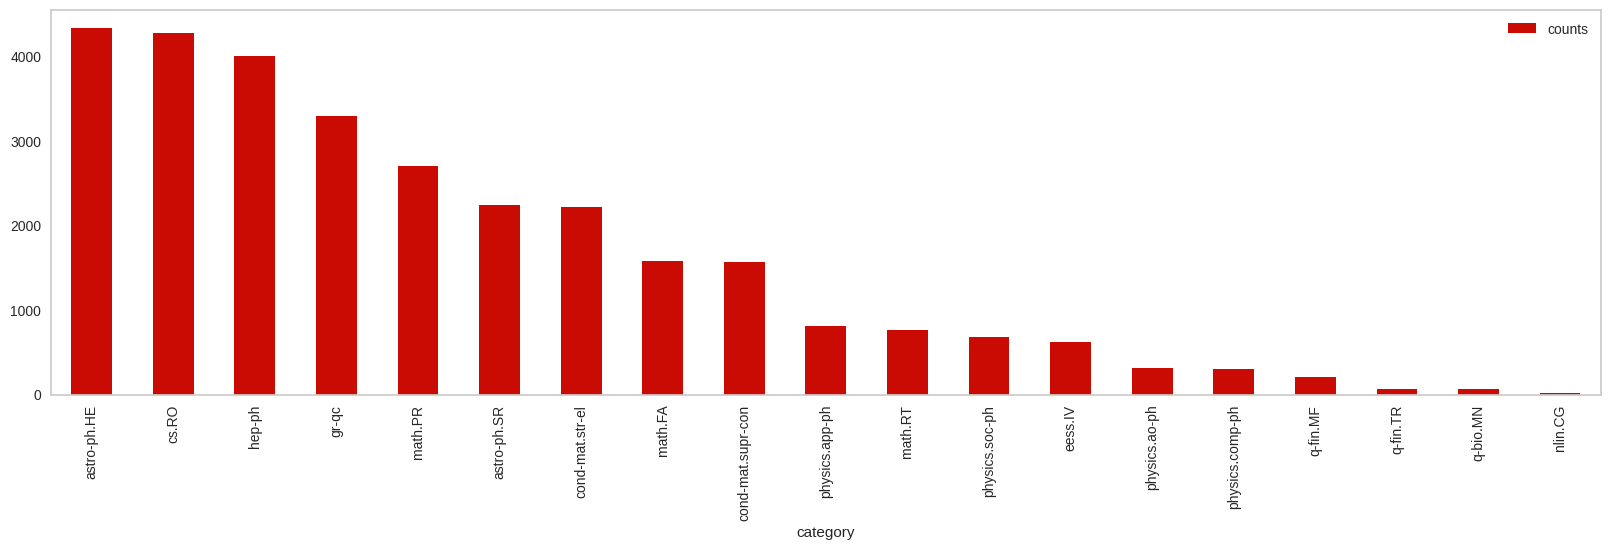

## 4.1 Prepare features

Given an article:
- if `features == "keywords"`, its feature will be the list of its keywords
- if `features == "clean_text"`, its feature will be the clean text (abstract + title)


In [8]:
features = "clean_text"
# features = "keywords"

if features == "clean_text":
    # Preparing X (features).
    X = df["clean_text"]


elif features == "keywords":
    X = df["keywords"].map(lambda x: " ".join(x))

X = X.to_numpy()

## 4.2 Prepare labels

Given an article:
- its label y will be its lists of categories (in a one-hot-encoding)

In [9]:
utils.categories_as_lists(df) # take "category" as a column of lists
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(df["category"]) # y is now one-hot encoded
classes = mlb.classes_ # names of the columns of the one-hot-encoding

# Visualize y.
y_df = pd.DataFrame(y, columns=classes)
y_df

,astro-ph.HE,astro-ph.SR,cond-mat.str-el,cond-mat.supr-con,cs.RO,eess.IV,gr-qc,hep-ph,math.FA,math.PR,math.RT,nlin.CG,physics.ao-ph,physics.app-ph,physics.comp-ph,physics.soc-ph,q-bio.MN,q-fin.MF,q-fin.TR
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26904,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
26905,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
26906,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
26907,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


## 4.3 Do the classification with the best train/test split

In [16]:
msss = MultilabelStratifiedShuffleSplit(n_splits=10, test_size=0.2,
                                        random_state=SEED)

ovr = OneVsRestClassifier(LinearSVC(class_weight='balanced'),
                          n_jobs=-1)

model = Pipeline([('tfidf', TfidfVectorizer(stop_words='english')),
                  ('svm_model', ovr)])


# Find the train/test split that maximizes f1-score.
f0 = 0
best_f = 0
for train_index, test_index in msss.split(X, y):
   X_train, X_test = X[train_index], X[test_index]
   y_train, y_test = y[train_index], y[test_index]

   # Fit the train data.
   model.fit(X_train, y_train)

   # Make predictions on the test data.
   y_pred = model.predict(X_test)
   mat = multilabel_confusion_matrix(y_test, y_pred)

   f = f1_score(y_test, y_pred, average='weighted')
   print(f'f1_weighted = {round(f,3)}')

   if f>f0:
       best_f = f
       best_X_train, best_X_test = X_train, X_test
       best_y_train, best_y_test = y_train, y_test
       best_y_pred, best_mat = y_pred, mat

   f0 = best_f

print(f'best f1_weighted = {round(best_f,3)}\n')

f1_weighted = 0.911
f1_weighted = 0.906
f1_weighted = 0.909
f1_weighted = 0.909
f1_weighted = 0.909
f1_weighted = 0.903
f1_weighted = 0.906
f1_weighted = 0.91
f1_weighted = 0.906
f1_weighted = 0.906
best f1_weighted = 0.911



dict_values([4337, 4274, 4004, 3298, 2701, 2243, 2215, 1576, 1565, 809, 765, 687, 621, 318, 304, 204, 66, 63, 17])

## 4.4 Show results

See the classification report.

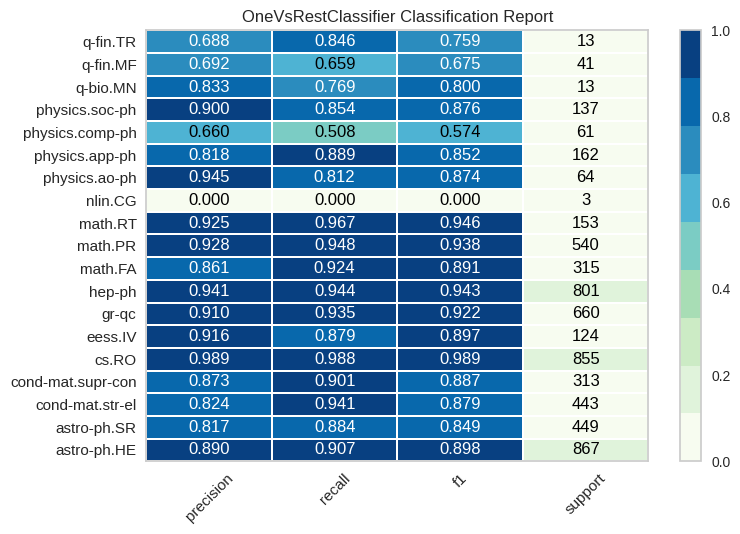

<Axes: title={'center': 'OneVsRestClassifier Classification Report'}>

In [21]:
visualizer = ClassificationReport(model, classes=classes, support=True,
                                  cmap='GnBu', fontsize=11)
visualizer.fit(best_X_train, best_y_train)
visualizer.score(best_X_test, best_y_test) # evaluate the model on the test data
visualizer.show()

Plot confusion matrices.

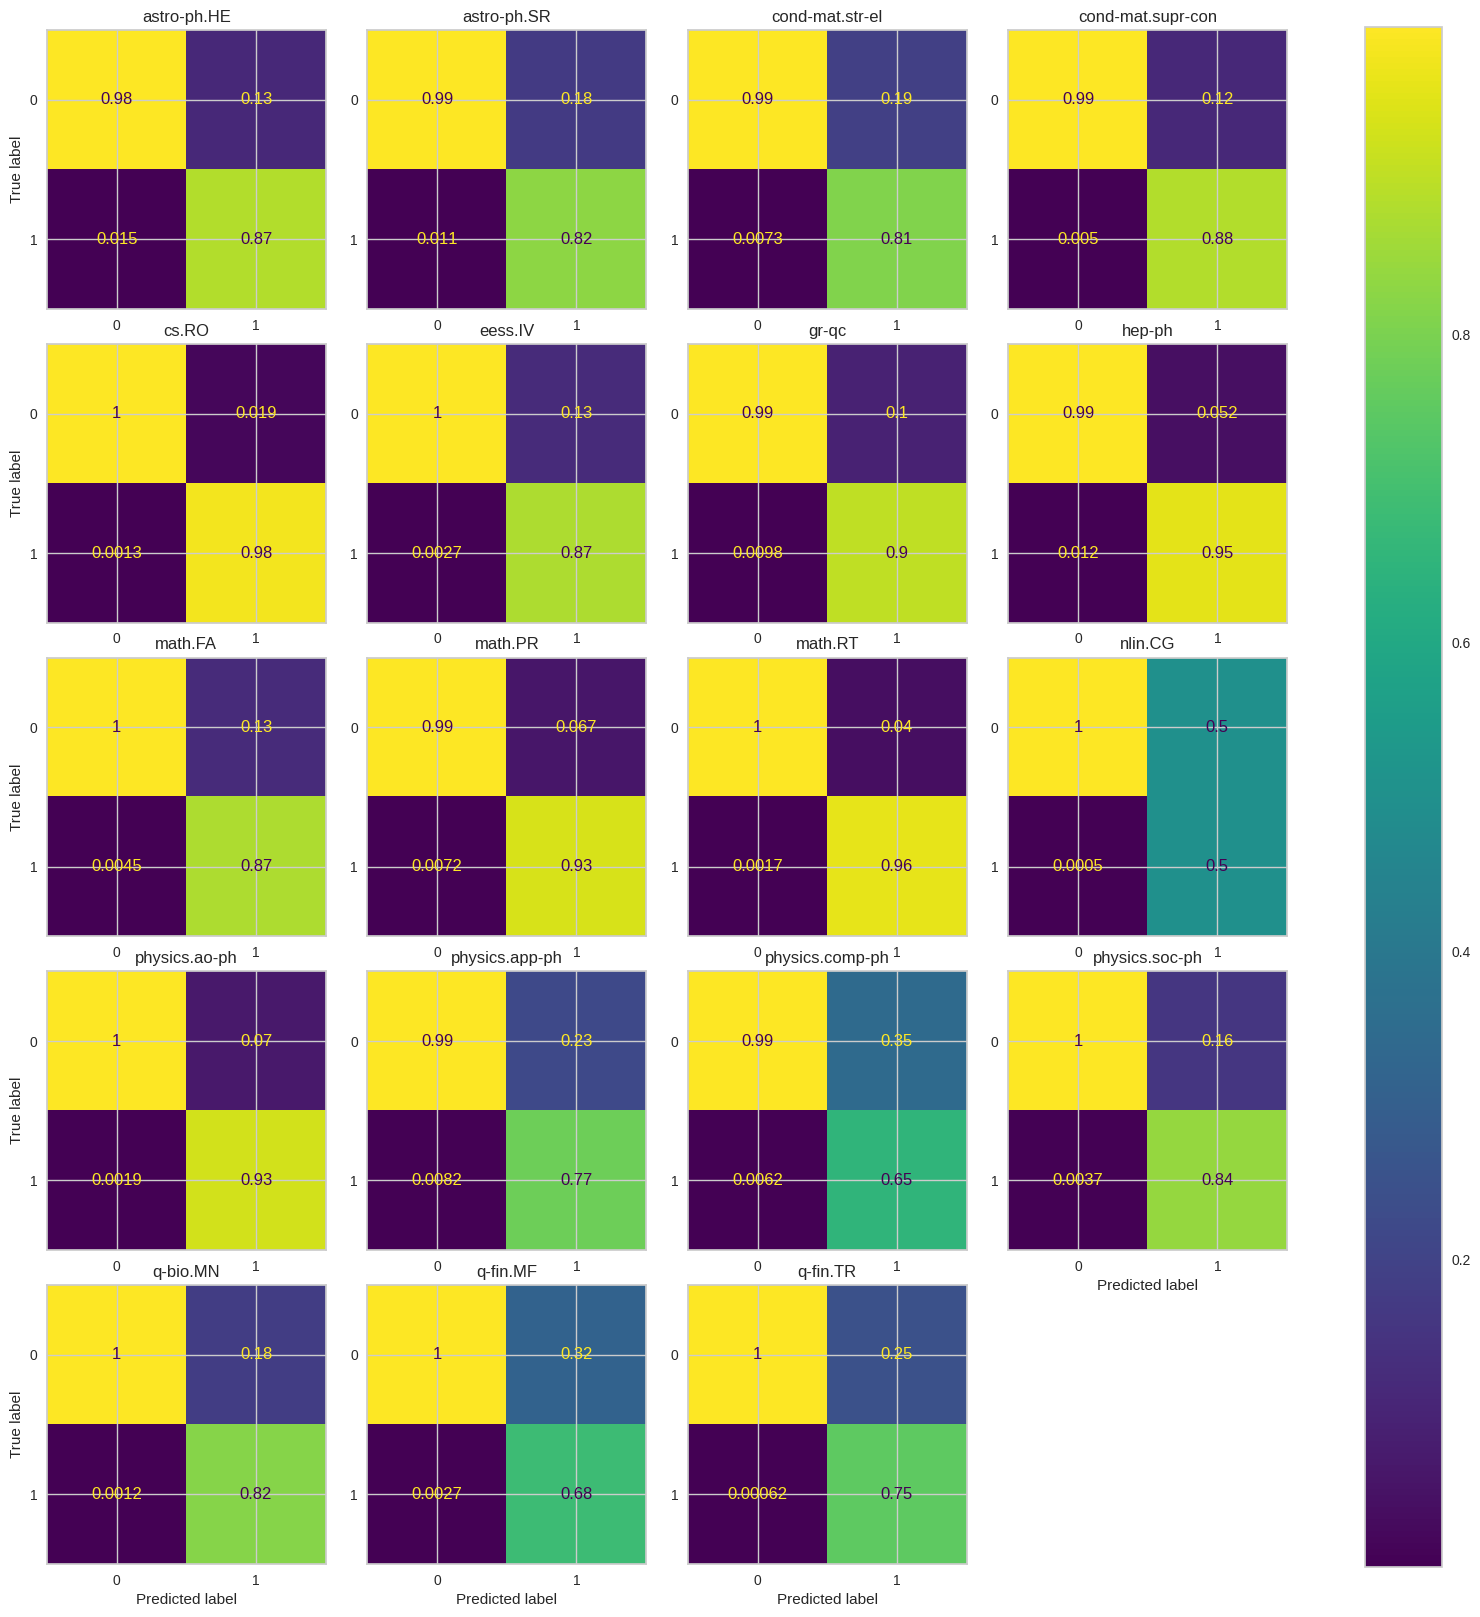

In [12]:
utils.plot_confusion_matrices(mat, classes)

(Optional) Show some predictions.

In [13]:
# Check the first 10 predictions.
y_test_list = mlb.inverse_transform(y_test)[:10]
y_pred_list = mlb.inverse_transform(y_pred)[:10]

for yt, yp in zip(y_test_list, y_pred_list):
  print("-"*20)
  print(f"  true   : {yt}")
  print(f"predicted: {yp}")

--------------------
  true   : ('physics.soc-ph',)
predicted: ()
--------------------
  true   : ('gr-qc',)
predicted: ('gr-qc',)
--------------------
  true   : ('hep-ph',)
predicted: ('hep-ph',)
--------------------
  true   : ('cond-mat.str-el', 'cond-mat.supr-con')
predicted: ('cond-mat.supr-con',)
--------------------
  true   : ('cond-mat.supr-con',)
predicted: ('cond-mat.str-el', 'cond-mat.supr-con')
--------------------
  true   : ('math.RT',)
predicted: ('math.RT',)
--------------------
  true   : ('math.PR',)
predicted: ('math.PR',)
--------------------
  true   : ('gr-qc',)
predicted: ('gr-qc',)
--------------------
  true   : ('math.PR',)
predicted: ('math.PR',)
--------------------
  true   : ('math.PR',)
predicted: ('math.PR',)


Plot the ROC curve.

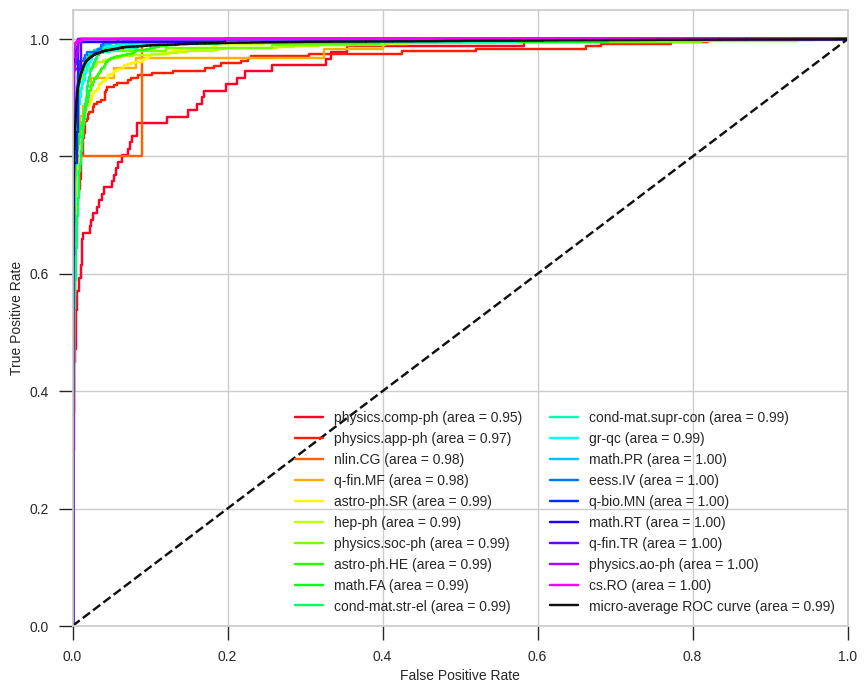

In [14]:
y_score = model.fit(X_train, y_train).decision_function(X_test)
utils.ROC(classes, y_test, y_score)

Plot the Precision-Recall curve.

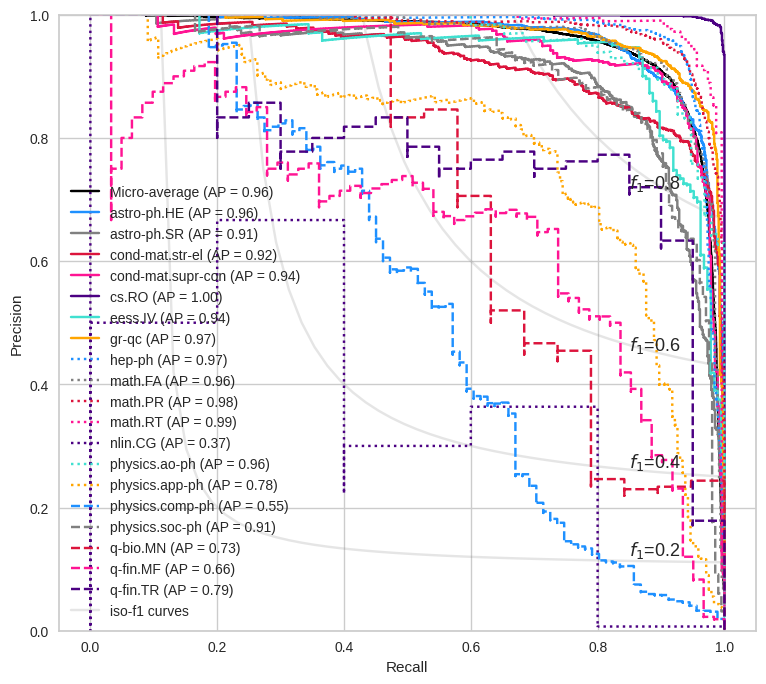

In [15]:
utils.PRC(classes, y_test, y_score)